# Understanding the dataset

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Convering MNIST Images to tensors

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root = './data', train = True, download= True, transform=transform)

In [5]:
test_data = datasets.MNIST(root = './data', train = False, download= True, transform=transform)

In [6]:
image, label = train_data[0]

In [7]:
# 1 indicates grayscale, 3 would be RGB
image.shape

torch.Size([1, 28, 28])

In [8]:
label

5

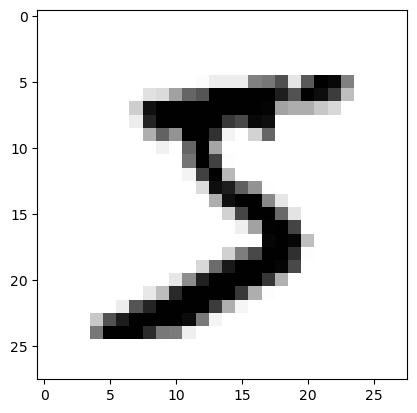

In [9]:
plt.imshow(image.reshape((28,28)), cmap='gist_yarg')
plt.show()

### Some ideas about image processing and computer vision

In [10]:
# Filters are image kernels - a small matrix of weights/values applied to an entire image
# We "stride" this filter across the entire image
# Visualization https://setosa.io/ev/image-kernels
# NNs will change the wts for this filters to do apt feature extraction

### Rather than loading all of the dataset at once, we will load a subset/batch.

In [11]:
# Controls randomization
torch.manual_seed(101)
# shuffling is important in case the data is ordered by class
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)

test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [12]:
# 1 - Grayscale, 6 - Number of filters of feature maps we want to have, 3*3 - kernel size, 1 is the stride, no padding needed as all images are centred and we can afford to lose edge data
# conv1 = nn.Conv2d(1,6,3,1)
# pooling layer and then the next one
# conv2 = nn.Conv2d(6,16,3,1)

In [13]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X): 
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim = 1)

In [14]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

# Model Training

In [17]:
import time
start_time = time.time()
epochs = 5
test_losses = []
train_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_correct = 0
    tst_correct = 0
    for b, (x_train, y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_correct += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (b%600 == 0):
            print(f"EPOCH : {i} BATCH : {b} LOSS: {loss.item()}")
    train_losses.append(loss.item())
    train_correct.append(trn_correct)

    with torch.no_grad():
        for b, (x_test, y_test) in enumerate(test_loader):
            y_val = model(x_test)

            predicted = torch.max(y_val.data,1)[1]
            tst_correct += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_correct)

        
current_time = time.time()
total = current_time - start_time
print(f"Training took {total/60} minutes")

EPOCH : 0 BATCH : 600 LOSS: 0.04045899957418442
EPOCH : 0 BATCH : 1200 LOSS: 0.07559646666049957
EPOCH : 0 BATCH : 1800 LOSS: 0.3719866871833801
EPOCH : 0 BATCH : 2400 LOSS: 0.020377913489937782
EPOCH : 0 BATCH : 3000 LOSS: 0.006640676409006119
EPOCH : 0 BATCH : 3600 LOSS: 0.0025554965250194073
EPOCH : 0 BATCH : 4200 LOSS: 0.4508979916572571
EPOCH : 0 BATCH : 4800 LOSS: 0.0150034474208951
EPOCH : 0 BATCH : 5400 LOSS: 0.0035691172815859318
EPOCH : 0 BATCH : 6000 LOSS: 0.05313171073794365
EPOCH : 1 BATCH : 600 LOSS: 0.015140739269554615
EPOCH : 1 BATCH : 1200 LOSS: 0.05636635422706604
EPOCH : 1 BATCH : 1800 LOSS: 0.0012728013098239899
EPOCH : 1 BATCH : 2400 LOSS: 0.02415573224425316
EPOCH : 1 BATCH : 3000 LOSS: 0.2880892753601074
EPOCH : 1 BATCH : 3600 LOSS: 0.0008119273115880787
EPOCH : 1 BATCH : 4200 LOSS: 0.00049273029435426
EPOCH : 1 BATCH : 4800 LOSS: 0.0006699974765069783
EPOCH : 1 BATCH : 5400 LOSS: 0.0023603534791618586
EPOCH : 1 BATCH : 6000 LOSS: 0.15053242444992065
EPOCH : 2 B

# Model Evaluation

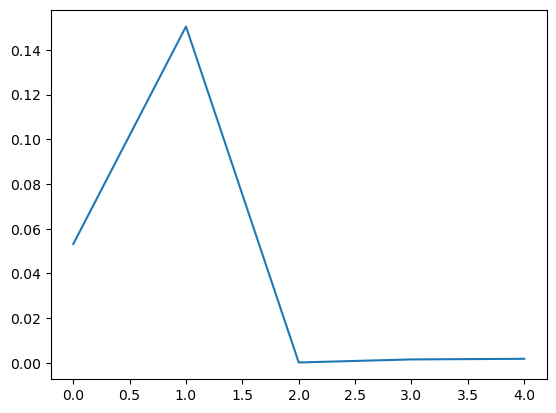

In [18]:
plt.plot(train_losses)
plt.show()

In [49]:
train_losses

[0.0012612816644832492,
 4.315330443205312e-06,
 7.390966629827744e-07,
 8.249013262684457e-06,
 0.12434743344783783]